# Capture population structure with PCA

> This notebook show how to retrieve phenotype data, load genotype data and perform Principal Component Analysis (PCA) with packages bigstatsr and bigsnpr (Privé, Aschard, and Blum 2017). 
> I also show why pruning and removing long-range Linkage Disequilibrium (LD) are two important steps before computing PCs in order to capture population structure (Abdellaoui et al. 2013).

It is dependent on Subsidiary Notebook **107** to generate files prefixed *maf_flt_8chroms*


- runtime: 30min 
- recommended instance: mem1_ssd1_v2_x16
- cost: ~£0.70

This notebook depends on:
* **A Spark instance**
* **Notebook 107** - maf_flt_8chroms* prefixed files

## Install required packages

Function `p_load` from `pacman` loads packages into R.
If a given package missing it will be automatically installed - this can take a considerable amount of time for packages that need C or FORTRAN code compilation.

The following packages are needed to run this notebook:

- `reticulate` - R-Python interface, required to use `dxdata` package that connects to Spark database and allows retrieval of phenotypic data 
- `dplyr` - tabular data manipulation in R, require to pre-process, encoding and filter phenotypic data
- `parallel` - parallel computation in R
- `bigsnpr` - run statistics on file-backed arrays, needed to calculate the approximate singular value decomposition (SVD) needed for PCA plots
- `bigparallelr` - controls parallel computation using file-backed arrays
- `ggplot2` - needed for graphics
- `readr` - read and write tabular file formats: CSV, CSV, tdf, etc.
- `hexbin` - plot PC loadings
- `skimr` - provide summary statistics about variables in data frames

In [ ]:
message('*** Installing packages, this may take 20 minutes! ***')

if(!require(pacman)) install.packages("pacman")
pacman::p_load(reticulate, dplyr, parallel, bigsnpr, ggplot2, readr, bigparallelr, hexbin, skimr, tidyverse, arrow)

message('*** Finished installing packages! ***')


## Import `dxdata` Python code and connect to spark cluster

In [2]:
dxdata <- import("dxdata")
project <- system("dx env | grep project- | awk -F '\t' '{print $2}'", intern = TRUE)
record <- system("dx describe *dataset | grep  record- | awk -F ' ' '{print $2}' | head -n1" , intern = TRUE)
DATASET_ID <- paste0(project, ":", record)
dataset <- dxdata$load_dataset(id=DATASET_ID)

pheno <- dataset$entities_by_name[['participant']]

## Retrieve the phenotype fields: `eid` and `Ethnic background | Instance 0`

In [3]:
fld = list(
    pheno$find_field(name="eid"),
    pheno$find_field(title="Ethnic background | Instance 0"))

engine <- dxdata$connect(dialect="hive+pyspark")
df <- pheno$retrieve_fields(engine=engine, fields=fld, coding_values="raw")

## Read Spark data into R

The code below does the following:

- exports data to parquet files on the Hadoop file system, 
- downloads as temporary files to a local file system
- reads parquet dataset and converts values to R object (`tibble`)

In [4]:
tmp_file <- basename(tempfile())
df$write$parquet(tmp_file)
system(paste('hadoop fs -copyToLocal', tmp_file), intern = TRUE)
ds <- arrow::open_dataset(tmp_file)

character(0)

## View the phenotypic data

> Note that data in field `p21000_i0` (`Ethnic background | Instance 0`) are encoded as numbers.
> To use them we need to translate this encoding to more informative text labels 

In [5]:
tbl <- ds %>% collect
summary(tbl)

     eid              p21000_i0   
 Length:502384      Min.   :  -3  
 Class :character   1st Qu.:1001  
 Mode  :character   Median :1001  
                    Mean   :1077  
                    3rd Qu.:1001  
                    Max.   :4003  
                    NA's   :899   

## Get `Ethnic background` field definitions and coding 

This step will allow us to convert from integer encoding to human-readable labels
We will need to get the coding and understand the hierarchy of codes.

In [6]:
fld0 <- pheno$find_field(title="Ethnic background | Instance 0")

### Preview the codes

In [7]:
fld0$coding$codes[sort(names(fld0$coding$codes))]

$`-1`
[1] "Do not know"

$`-3`
[1] "Prefer not to answer"

$`1`
[1] "White"

$`1001`
[1] "British"

$`1002`
[1] "Irish"

$`1003`
[1] "Any other white background"

$`2`
[1] "Mixed"

$`2001`
[1] "White and Black Caribbean"

$`2002`
[1] "White and Black African"

$`2003`
[1] "White and Asian"

$`2004`
[1] "Any other mixed background"

$`3`
[1] "Asian or Asian British"

$`3001`
[1] "Indian"

$`3002`
[1] "Pakistani"

$`3003`
[1] "Bangladeshi"

$`3004`
[1] "Any other Asian background"

$`4`
[1] "Black or Black British"

$`4001`
[1] "Caribbean"

$`4002`
[1] "African"

$`4003`
[1] "Any other Black background"

$`5`
[1] "Chinese"

$`6`
[1] "Other ethnic group"

### Preview the codes hierarchy

> Note: There are 2 levels in the encoding hierarchy of labels, 
> e.g. level 1 group `White` is sub-divided into three-level 2 labels 'British', 'Irish' and 'Any other white background'
> We will capture this structure as two columns in the de-coded table - one for Level 1 and second for Level 2 labels

In [8]:
fld0$coding$hierarchy

[[1]]
[[1]]$`1`
[1] "1001" "1002" "1003"


[[2]]
[[2]]$`2`
[1] "2001" "2002" "2003" "2004"


[[3]]
[[3]]$`3`
[1] "3001" "3002" "3003" "3004"


[[4]]
[[4]]$`4`
[1] "4001" "4002" "4003"


[[5]]
[1] "5"

[[6]]
[1] "6"

[[7]]
[1] "-1"

[[8]]
[1] "-3"

## Apply the coding to column `p21000_i0`

In this step, we use `mutate` function from `dplyr` package to convert numeric codes to human-readable labels.

In [ ]:
codes <- unlist(fld0$coding$codes)
tbl <- tbl %>% 
    mutate(ethnicity=codes[as.character(p21000_i0)]) %>%
    mutate(ethnicity0=codes[as.character(substr(p21000_i0, 1, 1))])
summary(tbl)

At this point, you can inspect your data. For example, you can print 5 first rows using the `head(tbl)` command.

## Sample participants with different ethnic backgrounds

Now, we have ethnicity data as a table with labels. We can use this structure to better understand the data.
First, we will count the occurrences of each label. Then, we will filter out mixed backgrounds and labels with a small number of occurrences.
Finally, we will sub-sample each label to match the number of the least numerous group that remained after filtering: 643


In [10]:
write.csv(tbl, file="ethnicity_processed.csv", quote=F, row.names=FALSE)
system("dx upload ethnicity_processed.csv --path pheno/")

### Calculate the number of participants with each Level 1 ethnicity label

In [11]:
tbl %>% 
    group_by(ethnicity0)  %>%  
    tally() %>%
    arrange(desc(n))

ethnicity0,n
<chr>,<int>
White,472587
Asian or Asian British,9879
Black or Black British,8058
Other ethnic group,4556
Mixed,2954
NA,2777
Chinese,1573


### Calculate the number of participants with each Level 2 ethnicity label

In [12]:
tbl %>% 
    group_by(ethnicity)  %>%  
    tally() %>%
    arrange(desc(n)) 

ethnicity,n
<chr>,<int>
British,442493
Any other white background,16324
Irish,13201
Indian,5951
Other ethnic group,4556
Caribbean,4515
African,3393
Pakistani,1835
Any other Asian background,1814


## Filter out participants without exome sequence based on EIDs

In this step, we first download a PLINK formatted fam file, that contains the unique IDs (EID) of individuals in the 450k Exome cohort.
We will exclude all participants that we do not have genotyped.
Example plink files can be created using Notebook **107**

In [20]:
system('dx download -f bed_maf/maf_flt_8chroms.*', intern = TRUE) 

character(0)

In [13]:
exome_eids <- read_delim(
    'maf_flt_8chroms.fam', 
    col_names = c('FID', 'IID', 'father', 'mother', 'sex', 'phenotype'),
    show_col_types = FALSE) %>% pull(IID) %>% as.character

summary(exome_eids)

   Length     Class      Mode 
   469835 character character 

In [ ]:
filtered <- tbl %>% 
    filter(eid %in% exome_eids)  %>%
    filter(ethnicity %in% c('African', 'British', 'Caribbean', 'Indian', 'Irish', 'Pakistani', 'Any other white background', 'Chinese'))
summary(filtered)

### Calculate the number of participants with each Level 2 label after applying a genotype filter 

In [15]:
grouped <- filtered %>% 
    group_by(ethnicity)   
grouped %>%  
    tally() %>%
    arrange(desc(n))

ethnicity,n
<chr>,<int>
British,414815
Any other white background,15228
Irish,12303
Indian,5492
Caribbean,4099
African,3037
Pakistani,1678
Chinese,1455


### Sample 643 individuals from each group  defined by level 2 labels

> Note: We initialize pseudorandom number generator used for sampling at reproducible state, to ensure the consistent output.

In [16]:
set.seed(0)
samples <- grouped %>% 
    sample_n(642, replace = FALSE)  

### Calculate the number of participants with each Level 2 label after applying a genotype filter  

> Note: Each group have now 643 unique individuals

In [17]:
samples %>%  
    tally() %>%
    arrange(desc(n))

ethnicity,n
<chr>,<int>
African,642
Any other white background,642
British,642
Caribbean,642
Chinese,642
Indian,642
Irish,642
Pakistani,642


Here is the filter used to extract sampled participants from 450k cohort BED/BIM/FAM files:

In [ ]:
str(which(exome_eids %in% samples$eid))

## Read and preview genotypes

The file we read in is `maf_flt_8chroms.bed` - this and corresponding *bim* and *fam* files must be located in the notebook’s working directory.

The `bigsnpr` package uses [Filebacked Big Matrices](https://privefl.github.io/bigstatsr/reference/FBM-class.html), which allows it to handle matrices that are too large to fit in memory. Hence, due to memory-mapping to binary files on disk, we first produce such files from PLINK formatted data and then attach them to the R environment.

In [19]:
#employ this filter
bedfile <- normalizePath("maf_flt_8chroms.bed")
tmpfile <- normalizePath("bigsnpr_input", mustWork = FALSE)
if( length(dir(pattern=tmpfile)) ) unlink(dir(pattern=tmpfile))
snp_readBed2(bedfile, backingfile = tmpfile, ind.row=which(exome_eids %in% samples$eid))

[1] "/opt/notebooks/bigsnpr_input.rds"

In [20]:
genotypes_smpl <- snp_attach(paste0(tmpfile, ".rds"))
names(genotypes_smpl)

[1] "genotypes" "fam"       "map"

`genotypes_smpl` is a list of 2 tables and one file-backed matrix:
- fam - participant information
- map - genomic map of variants
- genotypes - the matrix of genotypes [participant]x[variants]

In [ ]:
summary(genotypes_smpl$fam)

In [ ]:
head(genotypes_smpl$map)

In [23]:
genotypes_smpl$genotypes

A Filebacked Big Matrix of type 'code 256' with 5136 rows and 3767 columns.

## Calculate the PCA

In [24]:
options(bigstatsr.check.parallel.blas = FALSE)
NCORES = nb_cores()
assert_cores(NCORES)
message('INFO: Using ', NCORES, ' cores')

G   <- genotypes_smpl$genotypes
CHR <- genotypes_smpl$map$chromosome
POS <- genotypes_smpl$map$physical.pos
ind.excl <- snp_indLRLDR(infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)
ind.keep <- snp_clumping(G, infos.chr = as.integer(as.factor(CHR)),exclude = ind.excl,ncores = NCORES)
obj.svd <- big_randomSVD(G, fun.scaling = snp_scaleBinom(), ind.col = ind.keep, ncores = NCORES)

INFO: Using 71 cores



## Prepare `pca` object by joining PCA results with phenotypic table

In [ ]:
pca <- cbind(genotypes_smpl$fam$sample.ID, obj.svd$u)
colnames(pca) <- c('eid', paste0('PC', 1:10))

pca <- pca %>% as_tibble %>% left_join(samples %>% mutate(eid=as.numeric(eid)), by = 'eid')

summary(pca)

## Calculate the variance captured by each component

In [26]:
variance_captured <- round(obj.svd$d^2/sum(obj.svd$d^2), 2)*100

In [27]:
cat(paste0(variance_captured, '%'))

40% 29% 13% 3% 2% 2% 2% 2% 2% 2%

## Plot PCA using `ggplot2` package

### Examine the basic (level 1) ethnicity group on the PCA plot

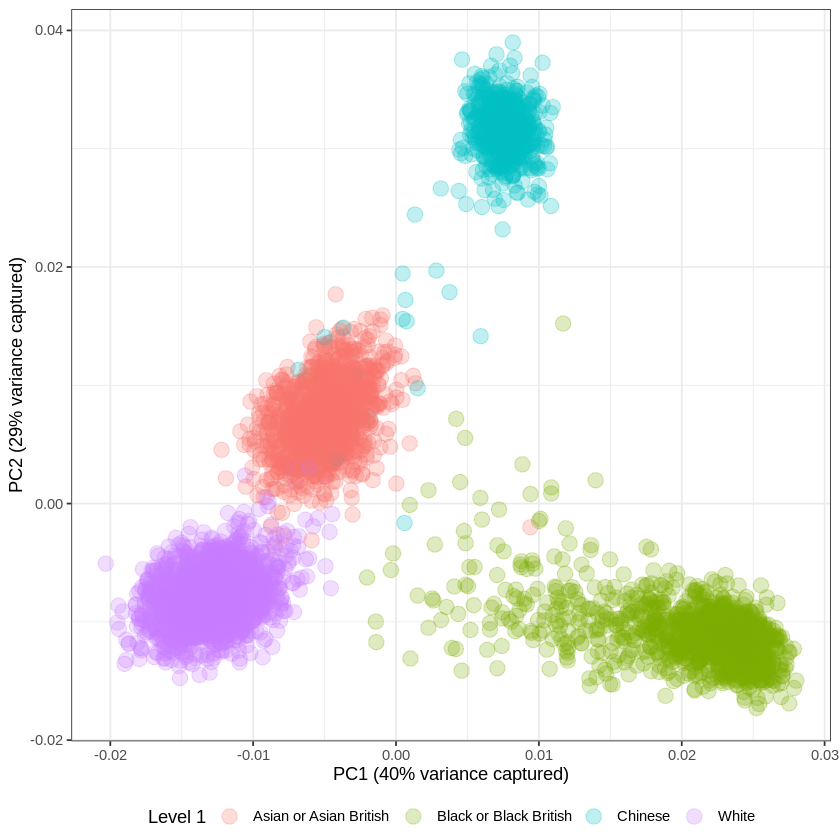

In [28]:
pca  %>%
    ggplot(aes(x=PC1, y=PC2, color=ethnicity0)) +
    geom_point(alpha=0.25, size=4) +
    theme_bw() +
    theme(legend.position="bottom") +
    theme(legend.box="vertical", legend.margin=margin()) +
    labs(color = "Level 1") +
    xlab(paste0('PC1 ', '(', variance_captured[1], '% variance captured)')) +
    ylab(paste0('PC2 ', '(', variance_captured[2], '% variance captured)'))

### Examine detail (level 2) ethnicity group on PCA plot

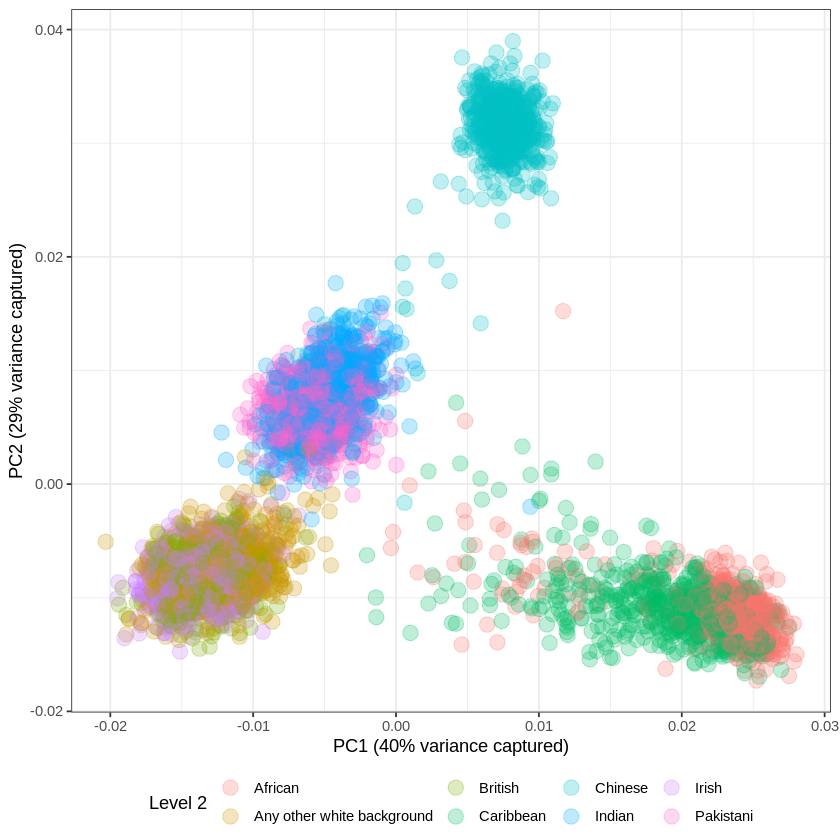

In [29]:
pca  %>%
    ggplot(aes(x=PC1, y=PC2, color=ethnicity)) +
    geom_point(alpha=0.25, size=4) +
    theme_bw() +
    theme(legend.position="bottom") +
    theme(legend.box="vertical", legend.margin=margin()) +
    labs(color = "Level 2") +
    xlab(paste0('PC1 ', '(', variance_captured[1], '% variance captured)')) +
    ylab(paste0('PC2 ', '(', variance_captured[2], '% variance captured)'))

### Combine information from both levels into a single plot

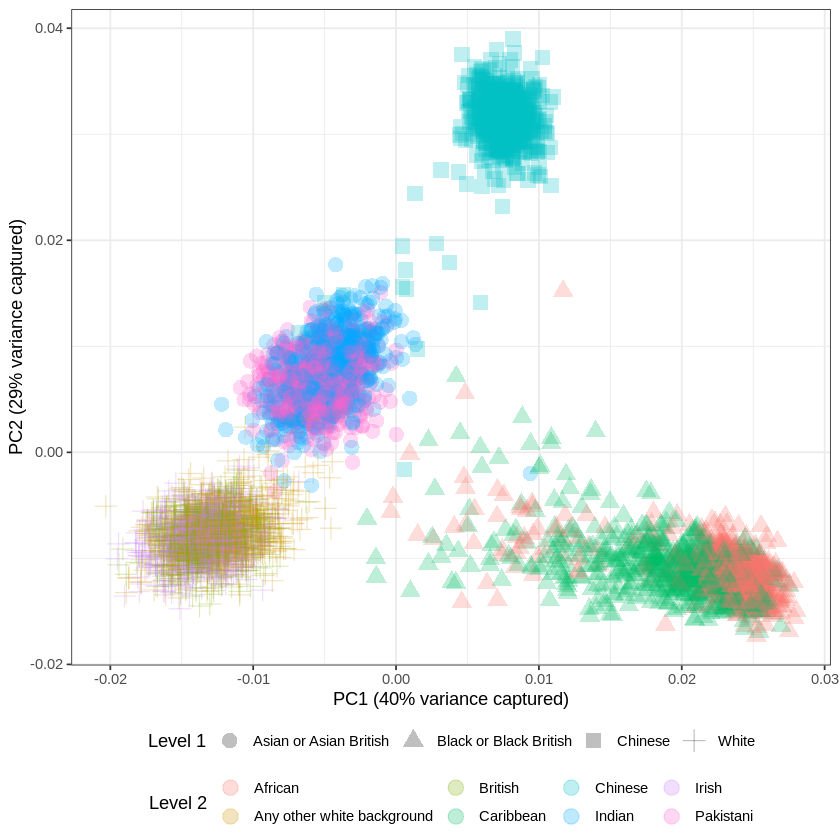

In [30]:
pca  %>%
    ggplot(aes(x=PC1, y=PC2, color=ethnicity, shape=ethnicity0)) +
    geom_point(alpha=0.25, size=4) +
    theme_bw() +
    theme(legend.position="bottom") +
    theme(legend.box="vertical", legend.margin=margin()) +
    labs(shape="Level 1", color = "Level 2") +
    xlab(paste0('PC1 ', '(', variance_captured[1], '% variance captured)')) +
    ylab(paste0('PC2 ', '(', variance_captured[2], '% variance captured)'))

## Examine the effect of pruning and removing long-range Linkage Disequilibrium (LD)

Here, we examine the loadings on principal components. 
This indicates which regions of the genome contributed to variance captured in a given principal component.

As we see, because of pruning and removing long-range Linkage Disequilibrium steps we have quite uniform loadings across the principal components. 

Here we demonstrate the extremes of PCs - (PCs1-4 versus PCs7-10)

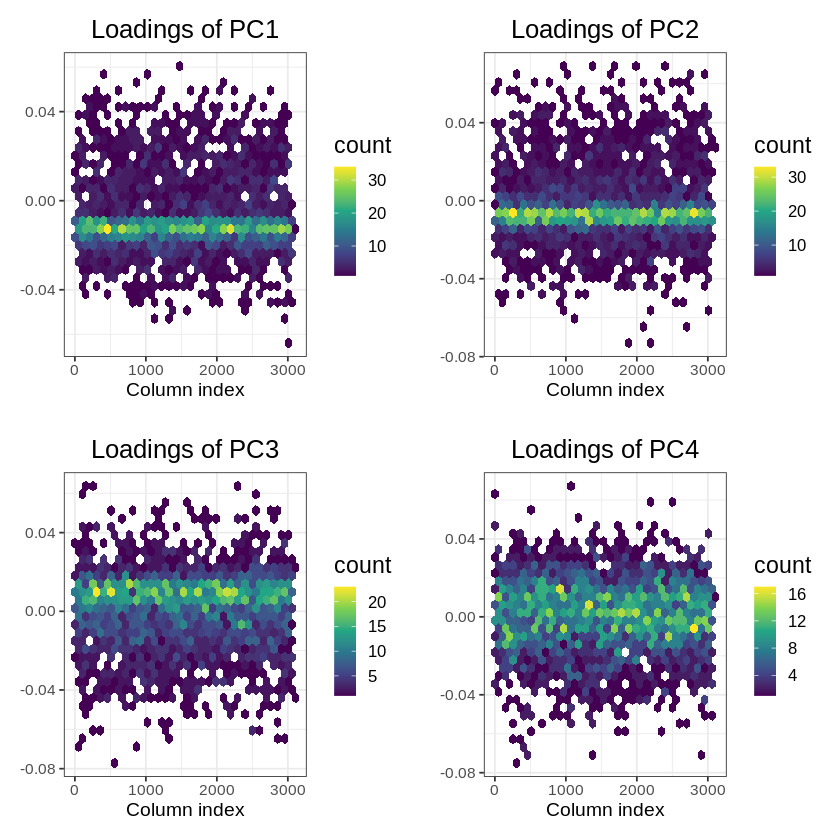

In [31]:
plot(obj.svd, type = "loadings", loadings = 1:4, coeff = 0.7)


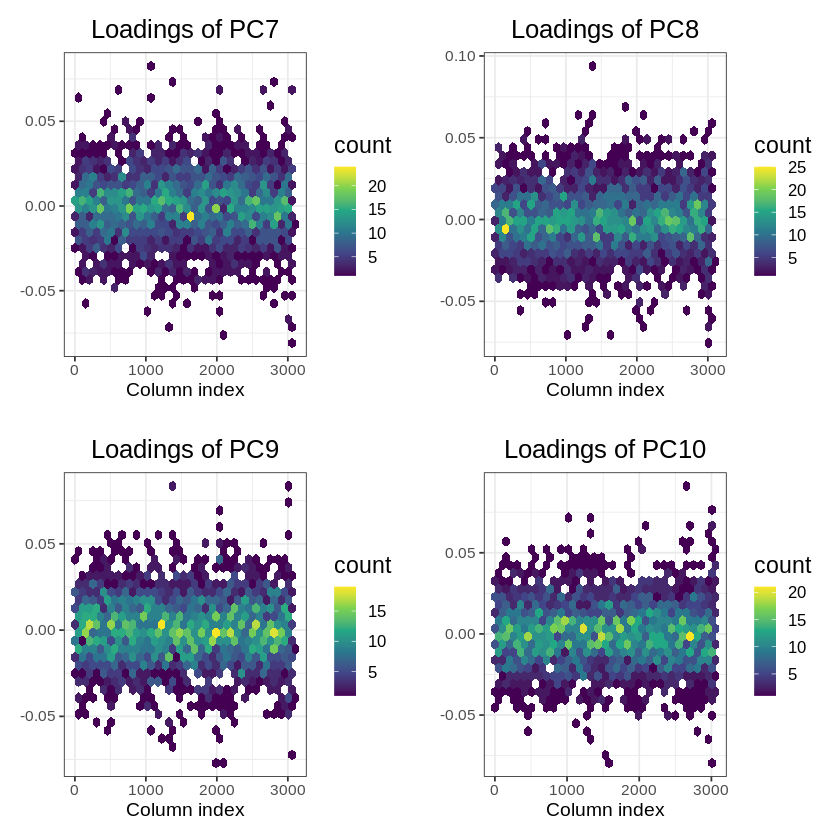

In [32]:
plot(obj.svd, type = "loadings", loadings = 7:10, coeff = 0.7)

Now, we calculate the SVD again, but this time omitting Linkage Disequilibrium pruning.
The loadings on PC1-3 are still quite uniformly distributed, but loadings on further components identify the specific regions in the genome that mostly contributed to the captured variance (column index represents the approximation of genomic coordinates).
This PCA would perform worse in capturing the structure of the population.

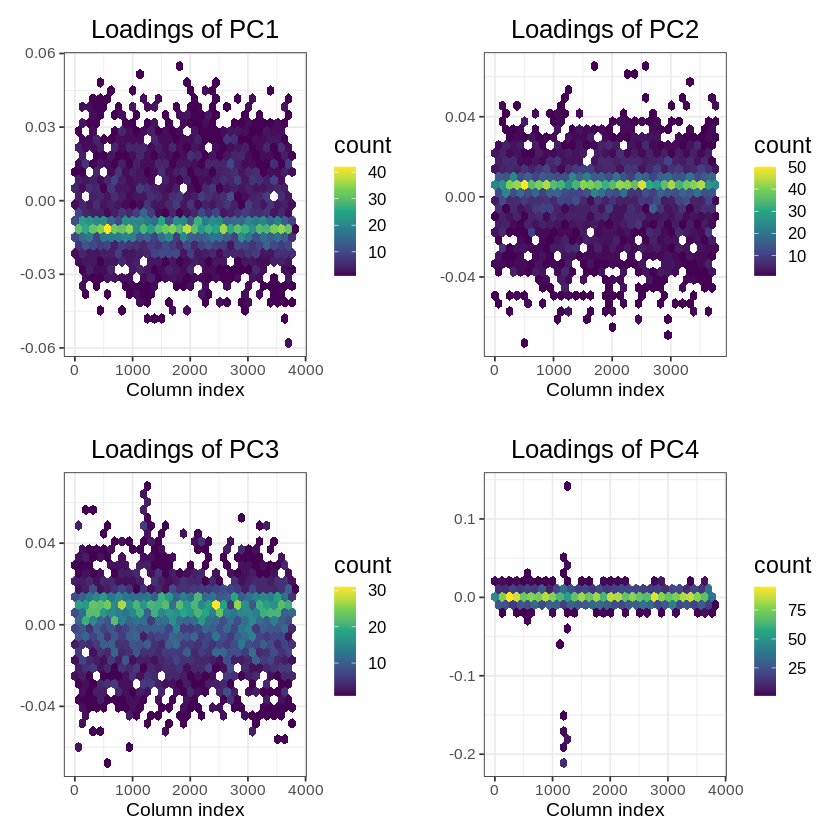

In [33]:
svd1 <- big_randomSVD(G, snp_scaleBinom(), ncores = NCORES)
plot(svd1, type = "loadings", loadings = 1:4, coeff = 0.7)

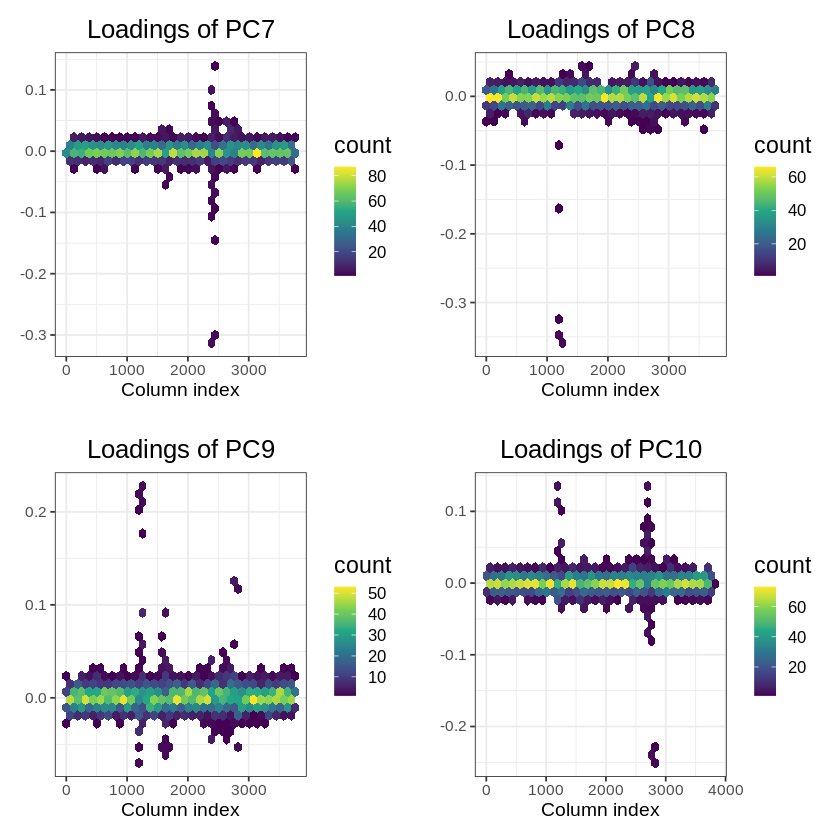

In [34]:
plot(svd1, type = "loadings", loadings = 7:10, coeff = 0.7)